# Timeseries modeling with neural networks

This tutorial will go through the process of fitting a neural network to timeseries data in Pytorch. First, by using a simple multilayer perceptron (MLP) and second, by using an auto-encoder network (AE).

Generally, what steps the pipeline contains:
- Preprocessing the data: variable selection, formatting, standardizing, decision of splitting
- Specifying your model class (neural_networks/models_nn.py)
- First data split: Architecture and Hyperparameter search for the model (neural_networks/random_search.py)
- Second data split: Network optimization (neural_networks/training.py)
- Third data split: Evaluation

## Set up your working space

Depending on the data you use, you might need to do your computations on a high performance cluster (HPC). Instructions for accessing the bwUniCluster follow.
This tutorial, however you will be able to pursue on your own computer.

Use either:
- Pycharm (useful, as it allows you to access a HPC from the IDE)
- Sypder with Anaconda (convenient handling, similar to RStudio)

Install the necessary packages: torch, torchvision.

## Supervised Learning: TS modelling with an MLP

The MLP does not have an internal structure that accounts for the temporal dependencies in the data. Yet, for uncomplicated temporal dependencies we can structure the data such that it does.
We do this by modelling the target variable as follows (here simplified, not accounting for layers or activation functions):
$y_t = b + aX_t + aX_{t-1} + ... +  aX_{t-i}$
Here, $X$ is the matrix of a batch of predicting variables that extend to a predefined history.

This is a workaround before using more complicated transformation types in your NN, such as RNN or LSTM layers.

In [1]:
import neural_networks.utils as utils
import matplotlib.pyplot as plt
import neural_networks.preprocessing as preprocessing
import neural_networks.random_search as random_search
import torch
import numpy as np
import neural_networks.models_nn as models

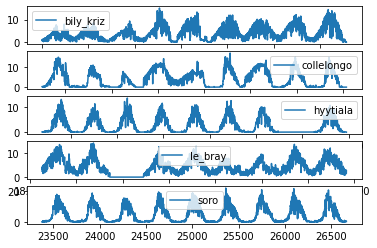

In [2]:
dfs = preprocessing.get_gpp()

In [3]:
x = dfs['GPP_ref'].values#torch.tensor(dfs['GPP_ref'].values)
print("Current shape of data:", x.shape)
xs = x.reshape(-1, 1)
print("New shape of data:", xs.shape)

Current shape of data: (7674,)
New shape of data: (7674, 1)


We need to split the data into the necessary chunks. Let's for simplicity here treat them as if we didn't knew about differences in source (this will not deliver a very good model, probably).

In [4]:
x_nas, x_train, x_test = utils.split(xs)
# see what happens to the data when we attach history
# better: move history as hyperparameter into NAS
x_nas, y_nas = utils.make_history(x_nas, history=3)
x_nas = np.transpose(np.squeeze(x_nas, axis=2))
input_dim = x_nas.shape[1]
output_dim = y_nas.shape[1]
print("Input dimension:", input_dim, "Output dimension:", output_dim)

Input dimension: 3 Output dimension: 1


Data is in right format now. Let's do the architecture search for the MLP in a very simple form with a maximum depth of three.

In [5]:
AS_grid = random_search.architecture_searchspace(input_dim, output_dim, gridsize = 30)
print(AS_grid)

x_nas, y_nas = torch.Tensor(x_nas), torch.Tensor(y_nas)
AS_results = random_search.architecture_search(x_nas, y_nas, AS_grid)

[[3, 8, 32, 1], [3, 32, 8, 1], [3, 8, 16, 1], [3, 4, 16, 8, 1], [3, 4, 1], [3, 8, 8, 1], [3, 16, 16, 1], [3, 16, 4, 4, 1], [3, 32, 1], [3, 16, 8, 1], [3, 16, 16, 4, 1], [3, 16, 8, 16, 1], [3, 4, 4, 16, 1], [3, 16, 32, 8, 1], [3, 32, 16, 1], [3, 16, 8, 32, 1], [3, 4, 16, 16, 1], [3, 32, 32, 1], [3, 32, 4, 8, 1], [3, 32, 4, 4, 1], [3, 32, 4, 1], [3, 8, 4, 1], [3, 4, 16, 32, 1], [3, 32, 4, 32, 1], [3, 8, 1]]
fitted model 0
fitted model 1
fitted model 2
fitted model 3
fitted model 4
fitted model 5
fitted model 6
fitted model 7
fitted model 8
fitted model 9
fitted model 10
fitted model 11
fitted model 12
fitted model 13
fitted model 14
fitted model 15
fitted model 16
fitted model 17
fitted model 18
fitted model 19
fitted model 20
fitted model 21
fitted model 22
fitted model 23
fitted model 24
Random architecture search best result:
    0   1   2    3   4  mae_train   mae_val
17  3  32  32  1.0 NaN   3.048603  2.925999


In [6]:
print(AS_results)

    0   1   2     3    4  mae_train   mae_val
0   3   8  32   1.0  NaN   3.066226  2.961246
1   3  32   8   1.0  NaN   3.087801  2.978560
2   3   8  16   1.0  NaN   3.064722  2.953107
3   3   4  16   8.0  1.0   3.072922  2.967999
4   3   4   1   NaN  NaN   3.026378  2.958511
5   3   8   8   1.0  NaN   3.023111  2.967925
6   3  16  16   1.0  NaN   3.121395  3.007373
7   3  16   4   4.0  1.0   3.077248  2.962615
8   3  32   1   NaN  NaN   3.115907  2.996902
9   3  16   8   1.0  NaN   3.097649  2.976712
10  3  16  16   4.0  1.0   3.066667  2.954743
11  3  16   8  16.0  1.0   3.078778  2.968441
12  3   4   4  16.0  1.0   3.080419  2.972447
13  3  16  32   8.0  1.0   3.067036  2.969101
14  3  32  16   1.0  NaN   3.048464  2.949687
15  3  16   8  32.0  1.0   3.094335  2.989649
16  3   4  16  16.0  1.0   3.093214  2.984083
17  3  32  32   1.0  NaN   3.048603  2.925999
18  3  32   4   8.0  1.0   3.082228  2.980810
19  3  32   4   4.0  1.0   3.065858  2.959815
20  3  32   4   1.0  NaN   3.12305

# Unsupervised learning: Timeseries modelling with the Auto-Encoder

From a simple Auto-Encoder, we expect our output to be the same as the input with reduced noise. This is realized with a bottleneck in the network architecture that allows only the most useful information to get through. The smaller the bottleneck, the lower the risk of overfitting - but too small might prevent important information to flow through.

Building blocks of an Auto-Encoder
- Encoder: Set of convolutional and pooling blocks.
- Bottleneck: The compressed representation of the input.
- Decoder: Upsampling and convolutional blocks.

The most important hyperparameters
- size of the bottleneck
- depth of the encoder and the decoder
- nodes per layer
- reconstruction loss

Types of Auto-Encoders (https://www.v7labs.com/blog/autoencoders-guide)
- Undercomplete: Unsupervised. Form of non-linear dimensionality reduction. Input is the same as output.
- Sparse: Regularized through an sparsity term in the loss function.
- Denoising: Input is a corrupted (noisy) version of the true data.
- Variational: Probabilistic representation of the latent space. Generational models.

In [ ]:
# Currently no architecture search for AE possible.
